# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 50

**Author 1 (sciper):** Hana Catic (370754)  
**Author 2 (sciper):** Jad Bhamdouni (370746)   

**Release date:** 19.04.2024  
**Due date:** 03.05.2024 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project that ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like OpenCV and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

TAs should be able to rerun your code end to end without having any issues. If not, you might lose part of the points during grading.

[iapr]: https://github.com/LTS5/iapr

In [84]:
%pip install numpy
%pip install matplotlib
%pip install pillow
%pip install pandas
%pip install scikit-learn
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
# Check is at least python 3.9
import sys 
# assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

Please take note that PyTorch will be utilized in this lab. PyTorch is a widely recognized library for deep learning. Prior to commencing the lab, we kindly ask you to review this quick tutorial available [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [86]:
import platform

# Get os name
os_name = platform.system().lower()
num_workers = 8

# OS X
if 'darwin' in os_name:
    print("Detected OS X")
    %pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.1
# Linux 
elif 'linux' in os_name:
    print("Detected Linux")
    %pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html
# Windows 
else:
    print("Detected Windows")
    num_workers = 0  # Hard fix for Windows users
    %pip install torch==1.8.1+cpu torchvision==0.9.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

Detected Windows


Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cpu (from versions: 2.0.0, 2.0.0+cpu, 2.0.0+cu117, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cu117, 2.0.1+cu118, 2.1.0, 2.1.0+cpu, 2.1.0+cu118, 2.1.0+cu121, 2.1.1, 2.1.1+cpu, 2.1.1+cu118, 2.1.1+cu121, 2.1.2, 2.1.2+cpu, 2.1.2+cu118, 2.1.2+cu121, 2.2.0, 2.2.0+cpu, 2.2.0+cu118, 2.2.0+cu121, 2.2.1, 2.2.1+cpu, 2.2.1+cu118, 2.2.1+cu121, 2.2.2, 2.2.2+cpu, 2.2.2+cu118, 2.2.2+cu121, 2.3.0, 2.3.0+cpu, 2.3.0+cu118, 2.3.0+cu121)
ERROR: No matching distribution found for torch==1.8.1+cpu

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
# Import main packages
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf

# Real-World Image Classification in Histopathology (30 points)

Supervised learning for classifying histopathology images, despite its capabilities, faces significant challenges. A primary obstacle is its reliance on labeled data, which is often scarce and costly to acquire due to the need for expert annotations. This scarcity can impede model performance, particularly when dealing with uncommon diseases or subtle pathological patterns. Moreover, supervised models may struggle with generalization to unseen data or variations in tissue staining protocols. 

This lab will concentrate on constructing classification models tailored for histopathology using the least labeled data possible. Since the lab does not center on computing descriptors for the images, only image features will be provided. Specifically, we utilized [CTransPath](https://github.com/Xiyue-Wang/TransPath), one of the most robust and precise existing image feature extractors in histopathology, as the descriptor. Your focus will be on classifying these features for downstream tasks crucial to histopathological analysis.

Before starting, make sure the data are located as follows:
```code
├── lab_03_iapr.ipynb
└── data
    └── data_lab_03
        ├── part_01
        │    ├── k16_train.pth
        │    ├── k16_val.pth
        │    ├── k16_test.pth
        │    └── k16.svg
        └── part_02
            ├── acinar.png
            ├── solid.png
            ├── wsi.png
            ├── DHMC_0001.png
            └── DHMC_0007.png
```

## Part 1 - Tumor, Stroma Classification in Colorectal Cancer Histopathology (11 points)

Colorectal cancer ranks among the most prevalent cancers affecting both men and women. Accurate diagnosis, supplemented with prognostic and predictive biomarker information, plays a pivotal role in patient monitoring and facilitating personalized treatment approaches. One crucial biomarker is the Tumor/Stroma ratio (TSR) observed in unhealthy colon tissues. This ratio serves as an indicator of cancer invasiveness, with higher ratios correlating to increased invasiveness and, consequently, diminished patient survival probabilities.

Traditionally, pathologists assess the TSR by visually inspecting unhealthy tissue samples under a microscope, relying on their expertise to estimate the ratio. However, given the large volume of samples and the occasional lack of precision in estimations, there arises a pressing need for automated recognition of various tissue types within histological images. The development of a multi-class classifier becomes imperative to accurately identify the diverse tissue types present. Typically, these tissue types include TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE, and EMPTY (background).

<br />
<figure>
    <img src="../data/data_lab_03/part_01/k16.svg" width="1100">
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology.</figcaption>
</figure>
<br />

Until now, state-of-the-art methodologies in histology have predominantly relied on deep-learning-based supervised learning techniques. However, a significant drawback of such an approach lies in the requirement for access to a meticulously annotated training dataset. Annotating histological data poses considerable challenges—it is a time-consuming process that demands the expertise of pathologists. Moreover, annotators are compelled to label every tissue type, even though only two (TUMOR and STROMA) are of primary interest.

To address these challenges, we propose an alternative approach. To streamline the annotation process, we task the annotator with labeling only the tissues of interest (TUMOR and STROMA), and discarding the rest. Subsequently, we aim to train a binary classifier capable of automatically recognizing these specific tissues during testing. This novel approach seeks to alleviate the burden of annotation while still enabling accurate identification of the critical tissue types. In this section, we will proceed with implementing and evaluating this proposed methodology.

In [88]:
dataroot = os.path.join("..", "data", "data_lab_03", "part_01")

# train features and labels
train_data = torch.load(os.path.join(dataroot, "k16_train.pth"))
train_x, train_y = train_data["features"], train_data["labels"]

# validation features and labels
val_data = torch.load(os.path.join(dataroot, "k16_val.pth"))
val_x, val_y = val_data["features"], val_data["labels"]

print("Distribution of data in train set")
print("#Tumor examples: {}".format(len(train_y[train_y == 0])))
print("#Stroma examples: {}".format(len(train_y[train_y == 1])))

print("\nDistribution of data in validation set")
print("#Tumor examples: {}".format(len(val_y[val_y == 0])))
print("#Stroma examples: {}".format(len(val_y[val_y == 1])))

Distribution of data in train set
#Tumor examples: 439
#Stroma examples: 439

Distribution of data in validation set
#Tumor examples: 93
#Stroma examples: 93


### 1.1 Binary classifier with Mahalanobis distance (2.5 pts)

Your task is to construct this binary classifier utilizing the Mahalanobis distance as taught in class. Begin by executing the cell below to load the training and validation features for TUMOR and STROMA. These features have been computed using a self-supervised model tailored for histopathology, known as CTransPath. Note that label `0` corresponds to TUMOR and label `1` to STROMA:

* **Q1 (1 pt)**: Complete the `fit` method in `MahalanobisClassifier`. This method calculates the parameters necessary for the Mahalanobis Classifier when fitted to the training data.
* **Q2 (1 pt)**: Complete the `predict` method in `MahalanobisClassifier`. This method is responsible for predicting the class for each test feature as well as the distance to class means using the Mahalanobis distance method.

**Note**: It is forbidden to use any prebuilt Mahalanobis distance function. You may only use `LedoitWolf` in `sklearn.covariance` for computing a stable covariance matrix.

In [89]:
class MahalanobisClassifier:
    """Mahalanobis based classifer"""

    def __init__(self):
        """
        Attributes:
            means (torch.tensor): (n_classes, d) Mean of the features for each class
            inv_covs (torch.tensor): (n_classes, d, d) Inverse of covariance matrix across d features for each class   
        """
        super().__init__()
        self.means = None
        self.inv_covs = None
        
    def fit(self, train_x : torch.Tensor, train_y : torch.Tensor):
        """Computes parameters for Mahalanobis Classifier (self.mean and self.cov), fitted on the training data.

        Args:
            train_x (torch.Tensor): (N, d) The tensor of training features
            train_y (torch.Tensor): (N,) The tensor of training labels
        """

        # Define number of classes
        n_classes = len(np.unique(np.unique(train_y)))
        n, d = train_x.shape
        
        # Set default values
        means = torch.zeros((n_classes, d), dtype=train_x.dtype)
        inv_covs = torch.ones((n_classes, d, d), dtype=train_x.dtype)
        
        # ------------------
        train_data = train_x.numpy()
        train_labels = train_y.numpy()
        
        for i in range(n_classes):
            means[i] = torch.from_numpy(np.mean(train_data[train_labels == i], axis = 0))
            inv_covs[i] = torch.linalg.inv(torch.from_numpy(LedoitWolf().fit(train_data[train_labels == i]).covariance_))
        # ------------------
            
        self.means = means
        self.inv_covs = inv_covs



    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        """Predicts the class of every test feature, using the Mahalanobis Distance

        Args:
            test_x (torch.Tensor): (N, d) The tensor of test features

        Returns:
            preds (torch.Tensor): (N,) The predictions tensor (id of the predicted class {0, 1, ..., n_classes-1})
            dists (torch.Tensor): (N, n_classes) Mahalanobis distance from sample to class means
        """

        # Define default output value
        N, d = test_x.shape
        dists = torch.zeros((N, self.means.shape[0]), dtype=test_x.dtype)
        preds = torch.zeros(N, dtype=test_x.dtype)
        
        # ------------------
        for i in range(N):
            min_dist = np.inf
            idx_min = -1
            for j in range(self.means.shape[0]):
                dists[i,j] = np.sqrt((test_x[i]-self.means[j])@self.inv_covs[j]@(test_x[i]-self.means[j]))
                if dists[i,j].item() < min_dist:
                    min_dist = dists[i,j]
                    idx_min = j
            preds[i] = idx_min
        # ------------------

        return preds, dists

In [90]:
def plot_mahalanobis_classifier(
    fa: torch.Tensor, fb: torch.Tensor, y: torch.Tensor, cls_name: list[str], colors: list[str], title: str):
    """Display Mahalanobis distances for the first two features over samples

    Args:
        fa (torch.Tensor): (N,) First feature component
        fb (torch.Tensor): (N,) Second feature component
        y (torch.Tensor): (N,) Class ground truth
        cls_name (list of str): (n_classes,) Name of classes as list
        title (str): Title of plot
    """
    
    # Create plot
    _, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Plot results
    for i, c in enumerate(np.unique(y)):
        ax.scatter(fa[y == c], fb[y == c], marker="o", c=colors[i], label="{}".format(cls_name[i]))
    
    # Labels
    ax.set_xlabel("Distance to Tumor")
    ax.set_ylabel("Distance to Stroma")
    plt.title(title)
    plt.legend()


* **Q3 (0.5 pt)**: After fitting your classifier on the training data, compute the accuracy of the validation data. Are you satisfied with the results? Your results should be above (97%).
    * **Answer**: The observed accuracy of the fitted classifier is 97.31%, which means that 5 out of total of 186 samples in validation are missclassified, which can be considered as outliers. It could be possible to find a linear classifier that misclassifies only 4 samples, but that can be considered as an insignificant improvement. Thus, we are satisfied with the results.

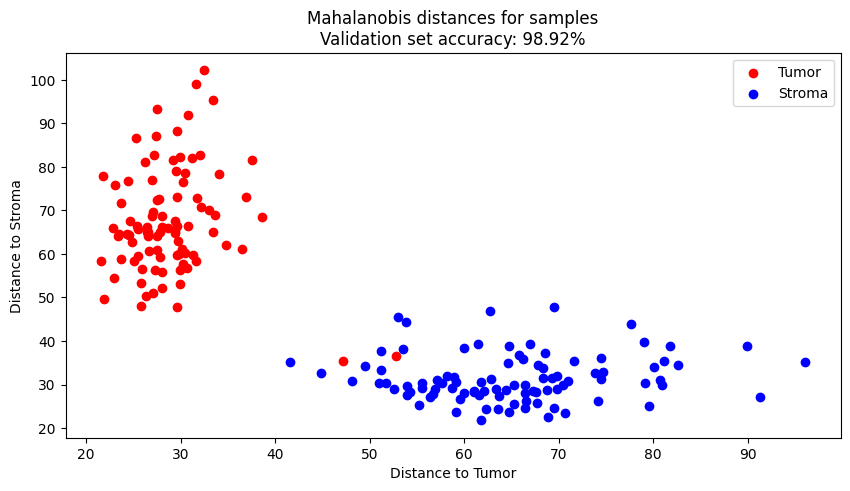

In [91]:
# Create classifier
classifier = MahalanobisClassifier()

# Fit to train data
classifier.fit(train_x, train_y)

# Apply on validation data and compute accuracy
val_y_hat, val_y_dist = classifier.predict(val_x)
accuracy = accuracy_score(val_y, val_y_hat)

# Plot results (distance to means and prediction of classes)
plot_mahalanobis_classifier(
    fa=val_y_dist[:,0] , fb=val_y_dist[:,1], y=val_y,
    cls_name=["Tumor", "Stroma"], colors=["r", "b"],
    title="Mahalanobis distances for samples\nValidation set accuracy: {:.2f}%".format(100*accuracy),
)

### 1.2 Out-of-Distribution detection with Mahalanobis distance (3.5 pts)

Your classifier appears to perform well. However, during testing, it's possible for other tissue types to be present, which cannot be manually filtered out. Moreover, these tissue types may not be recognized by the model as they fall outside the labeled training distribution (It is the consequence of the laziness of the annotators ;)). Therefore, it's crucial to filter out these out-of-distribution (OoD) samples.

One approach to OoD detection involves computing an OoD-ness score for each test example. This score should be low for in-distribution (ID) examples and high for OoDs. Subsequently, a threshold is defined, for which any example with a greater OoD-ness is discarded, while those below it are forwarded to the model for prediction. An example of an OoD-ness score is the minimum Mahalanobis distance to means.

* **Q1 (0.5 pt)**: Why do you think the minimum Mahalanobis distance is a good OoD-ness score?
    * **Answer**: ...

Start by running the cell below to load the test set. It comprises TUMOR and STROMA samples, along with other tissue types. Note that OoD tissues types are labeled to `-1`.

In [92]:
test_data = torch.load(os.path.join(dataroot, "k16_test.pth"))
test_x, test_y = test_data["features"], test_data["labels"]

# Display distribution of test samples
print("Distribution of data in test set")
print("#Tumor examples: {}".format(len(test_y[test_y == 0])))
print("#Stroma examples: {}".format(len(test_y[test_y == 1])))
print("#OoD examples: {}".format(len(test_y[test_y == -1])))

Distribution of data in test set
#Tumor examples: 93
#Stroma examples: 93
#OoD examples: 558


* **Q2 (0.5 pt)**: We create a new classifier `MahalanobisOODClassifier` that inherits from the previous one. Reimplement the function `predict` such that it returns as well the OoD scores. We define the `ood_scores` as the minimum Mahalanobis distance from the classifier. Your accuracy results should be the same as before.

In [93]:
class MahalanobisOODClassifier(MahalanobisClassifier):
    """Predicts the class of every test feature, using the Mahalanobis Distance

    Args:
        test_x (torch.Tensor): (N x d) The tensor of test features

    Returns:
        preds (torch.Tensor): (N,) The predictions tensor (id of the predicted class {0, 1, ..., n_classes-1})
        dists (torch.Tensor): (N, n_classes) Mahalanobis distance from sample to class means
        ood_scores (torch.Tensor): (N,) Score of OoDness as the minimal distance from the sample to classes
    """

    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        
        # Get super prediction (from MahalanobisClassifier)
        preds, dists = super().predict(test_x=test_x)
        N = preds.shape[0]

        # Assign dummy values to scores
        ood_scores = np.zeros(N)
        
        # ------------------
        # for i in range(N):
        #     ood_scores[i] = torch.min(dists[i])
        ood_scores = dists.min(axis=1).values # minimum Mahalanobis Distance
        # ------------------
        
        return preds, dists, ood_scores


In [94]:
def plot_mahalanobis_ood_classifier(
    fa: torch.Tensor, fb: torch.Tensor, ood_score: torch.Tensor, cls_name: list[str], title: str):
    """Display Mahalanobis distances for the first two features over samples as well as OoD scores.

    Args:
        fa (torch.Tensor): (N,) First feature component
        fb (torch.Tensor): (N,) Second feature component
        ood_score (torch.Tensor): (N,) OoDness of samples
        cls_name (list of str): (n_classes,) Name of classes as list
        title (str): Title of plot
    """
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Plot results
    pcm = ax.scatter(fa, fb, c=ood_score, marker="o", label="OoD score")
    
    # Labels
    ax.set_xlabel("Distance to Tumor")
    ax.set_ylabel("Distance to Stroma")
    fig.colorbar(pcm, ax=ax, label="OoD score")
    plt.title(title)
    plt.legend()


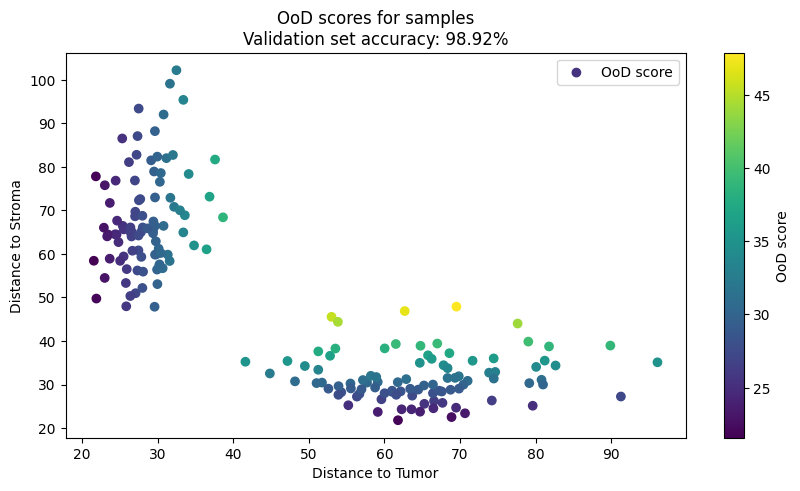

In [95]:
# Create classifier
classifier_ood = MahalanobisOODClassifier()

# Fit to train data
classifier_ood.fit(train_x, train_y)

# Apply on validation data and compute accuracy
val_y_hat, val_y_dist, val_y_ood_scores = classifier_ood.predict(val_x)
accuracy = accuracy_score(val_y, val_y_hat)

# Plot results (distance to means and prediction of classes)
plot_mahalanobis_ood_classifier(
    fa=val_y_dist[:,0] , fb=val_y_dist[:,1], ood_score=val_y_ood_scores,
    cls_name=["Tumor", "Stroma"],
    title="OoD scores for samples\nValidation set accuracy: {:.2f}%".format(100*accuracy),
)

* **Q3 (0.5 pt)**: Based on the validation set OoD scores, determine a threshold for the minimum Mahalanobis distance such that 95% of the validation samples are identified as ID.

In [96]:
def get_ood_threshold(ood_scores, quantile=0.95):
    """ Get OoD threshold based on measured scores and quantile

    Args:
        ood_scores (torch.Tensor): (N, ) N measured OoDness scores
        quantile (float): Percentage of samples that are considered as in distribution
    """

    # Set default value
    threshold = 0

    # ------------------
    # sorted, indicies = ood_scores.sort()
    # idx = int(quantile*sorted.size()[0])
    # threshold = (sorted[idx -1] + sorted[idx] + sorted[idx+1])/3
    # threshold = sorted[idx]
    threshold = torch.quantile(ood_scores, quantile)
    # ------------------

    return threshold

In [97]:
# Get threshold
q = 0.95
threshold_val = get_ood_threshold(ood_scores=val_y_ood_scores, quantile=q)

print("Validation threshold {:.0f}% = {:.2f}".format(100*q, threshold_val))

Validation threshold 95% = 38.87


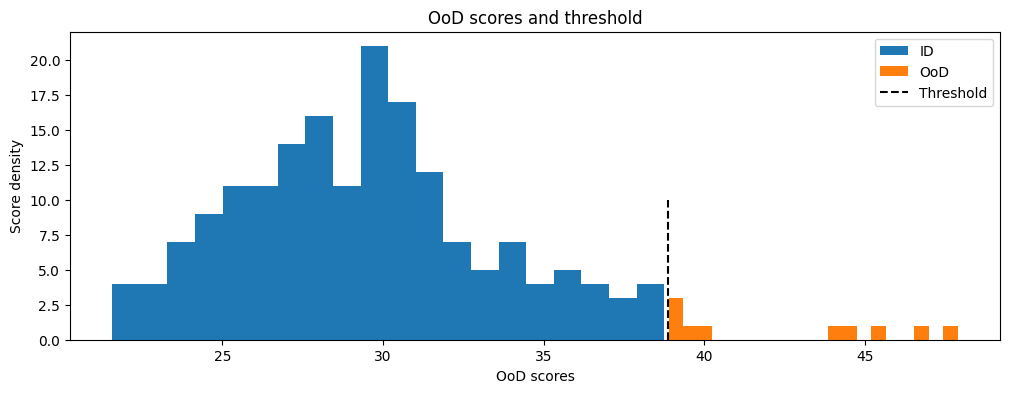

In [98]:
def plot_ood_scores(ood_scores: torch.Tensor, threshold: float):
    """ Plot OoD scores and the threshold to quantile.

    Args:
        ood_scores (torch.Tensor): (N, ) N measured OoDness scores
        threshold (float): OoD threshold
    """
    
    plt.figure(figsize=(12, 4))
    plt.hist(ood_scores[ood_scores <= threshold], bins=20, label="ID")
    plt.hist(ood_scores[ood_scores > threshold], bins=20, label="OoD")
    plt.vlines(threshold, ymin=0, ymax=10, color='k', ls='--', label="Threshold")
    plt.xlabel("OoD scores")
    plt.ylabel("Score density")
    plt.title("OoD scores and threshold")
    plt.legend()

# Plot ood scores and threshold
plot_ood_scores(ood_scores=val_y_ood_scores, threshold=threshold_val)

* **Q4 (2 pts)**: Complete the function `compute_metrics` that computes the recall for TUMOR, STROMA, and OoD examples as well as the average recall over the 3 classes. To do so, you need to consider OoDs as a third class by assigning the prediction `-1` to filtered-out examples based on your threshold. Based on your results, conclude on the feasibility of the proposed pipeline. Propose a solution that would require the least annotation possible but that could significantly increase your OoD recall. Both Tumor and Stroma recall should be above 90%. Recall for OOD should be above 80%.
    * **Answer**: ...

In [99]:
import sklearn
def compute_metrics(y, y_hat, ood_scores, threshold):
    """ Compute recall for tumor, stroma, and OoD as well as the average recall.

    Args:
        y (torch.Tensor): (N) Class ground truth {-1, 0, 1, ..., n_classes}
        y_hat (torch.Tensor): (N,) Class predictions {0, 1, ..., n_classes}
        ood_scores (torch.Tensor): (N, ) N measured OoDness scores
        threshold (float): OoD threshold

    Returns:
        recall_tumor (float): Tumor recall  
        recall_stroma (float): Stroma recall 
        recall_ood (float): OOD recall 
        avg_recal (float): Averaged recall
        y_hat_ood (torch.Tensor): (N,) Class predictions with oods {-1, 0, 1, ..., n_classes}
    """
    # Define variable with dummy values 
    recall_tumor = 0
    recall_stroma = 0
    recall_ood = 0
    avg_recall = 0
    y_hat_ood = np.zeros_like(y_hat)
    
    # ------------------
    #reminder: 0 is TUMOR
    
    ood_bool_vector = (ood_scores > threshold)  #points to put in ood
    y_hat[ood_bool_vector] = -1

    pred1 = (y_hat == 1)
    true1 = (y == 1)
    TP1 = torch.sum(pred1 & true1)  # true positives for class 1
    FN1 = torch.sum((~pred1) & true1)   # false positives for class 1
    recall_stroma = TP1/(TP1 + FN1)

    pred0 = (y_hat == 0)
    true0 = (y == 0)
    TP0 = torch.sum(pred0 & true0)
    FN0 = torch.sum((~pred0) & true0)
    recall_tumor = TP0/(TP0 + FN0)    

    pred_1 = (y_hat == -1)
    true_1 = (y == -1)
    TP_1 = torch.sum(pred_1 & true_1)
    FN_1 = torch.sum((~pred_1) & true_1)
    recall_ood = TP_1/(TP_1 + FN_1)

    avg_recall = (recall_tumor + recall_stroma + recall_ood) / 3    

    # ------------------

    return y_hat_ood, recall_tumor, recall_stroma, recall_ood, avg_recall


In [100]:
# Predictions on test set
test_y_hat, test_y_dist, test_y_ood_scores = classifier_ood.predict(test_x)

# Compute metrics
test_y_hat_ood, recall_tumor, recall_stroma, recall_ood, avg_recall = compute_metrics(
    y=test_y, y_hat=test_y_hat, ood_scores=test_y_ood_scores, threshold=threshold_val)

# Display metrics
print(f"Tumor recall: {recall_tumor*100:.2f}%")
print(f"Stroma recall: {recall_stroma*100:.2f}%")
print(f"OoD recall: {recall_ood*100:.2f}%")
print(f"Average recall: {avg_recall*100:.2f}%")


Tumor recall: 98.92%
Stroma recall: 92.47%
OoD recall: 86.02%
Average recall: 92.47%


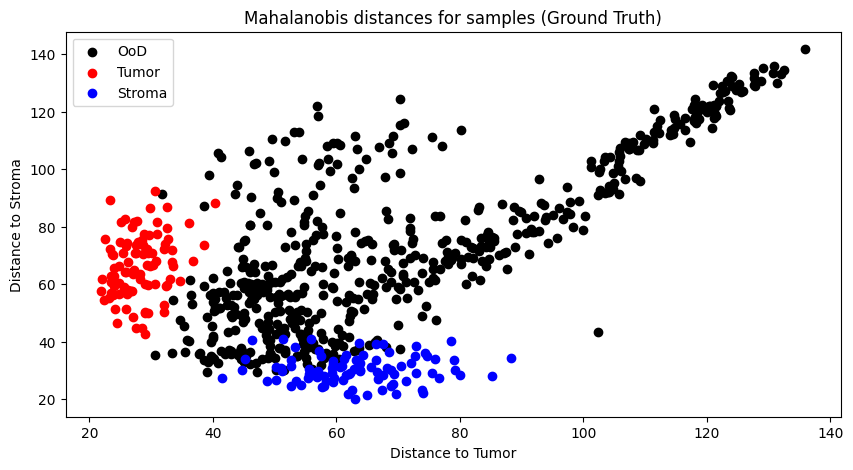

In [101]:
# Display the classification with OoD and features
plot_mahalanobis_classifier(
    fa=test_y_dist[:,0] , fb=test_y_dist[:,1], y=test_y,
    cls_name=["OoD", "Tumor", "Stroma"], colors=["k", "r", "b"],
    title="Mahalanobis distances for samples (Ground Truth)"
)

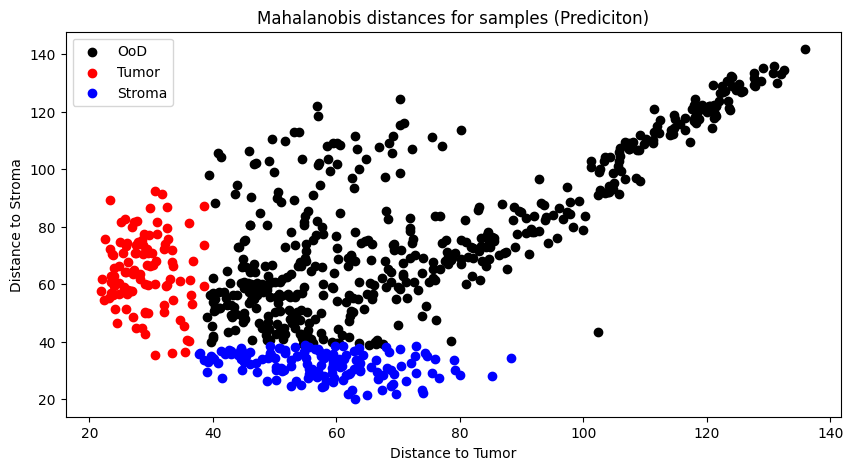

In [102]:
# Display the classification with OoD and features
plot_mahalanobis_classifier(
    fa=test_y_dist[:,0] , fb=test_y_dist[:,1], y=test_y_hat,
    cls_name=["OoD", "Tumor", "Stroma"], colors=["k", "r", "b"],
    title="Mahalanobis distances for samples (Prediciton)"
)

### 1.3 Out-of-Distribution detection with k-NN (5 pts)

Let's explore another technique based on k-Nearest Neighbors (k-NN). The features utilized have been extracted from a self-supervised model, known for their efficacy as k-NN classifiers. This motivates us to implement a k-NN classifier for identifying TUMOR and STROMA. Additionally, the k-NN distance serves as a suitable OoD-ness score, aligning well with our task requirements.

* **Q1 (2 pts)**: Complete the `fit` and `predict` functions in `kNNClassifier`. Also, assign your own handcrafted OoD score in `predict`. We recommend to use `top_k` function from torch ([doc](https://pytorch.org/docs/stable/generated/torch.topk.html)). When using k>1, use majority voting to select the winning class.

**Note**: It is forbidden to use any prebuilt k-NN classifier function.

In [103]:
class kNNClassifier:
    """k-NN based classifier"""

    def __init__(self, k : int):
        """
        Args:
            k (int): The number of neighbors to consider for the classification
            features (torch.Tensor): (N, d) feature of the N train samples
            labels (torch.Tensor): (N,) labels for train samples
        """
        self.k = k
        self.features = None
        self.labels = None

    def fit(self, train_x : torch.Tensor, train_y : torch.Tensor):
        """Store training data parameters (features and labels) for k-NN classifier.

        Args:
            train_x (torch.Tensor): (N, d) The tensor of training features
            train_y (torch.Tensor): (N,) The tensor of training labels
        """
        
        # Get size and default values
        N, d = train_x.shape
        features = torch.zeros((N, d))
        labels = torch.zeros(N)
        
        # ------------------
        features = train_x
        labels = train_y
        # ------------------

        self.features = features
        self.labels = labels

    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        """Predicts the class of every test feature, using the k-NN

        Args:
            test_x (torch.Tensor): (N x d) The tensor of test features

        Returns:
            preds (torch.Tensor): (N,) The tensor of class predictions {0, 1, ..., n_classes}
            ood_scores (torch.Tensor): (N,) The OoD score predictions
        """
                
        # Get size and default values
        N, d = test_x.shape
        preds = torch.zeros(N)
        ood_scores = torch.zeros(N)

        # ------------------

        for i in range(N):  # iterating over the testing points

            expanded_point = test_x[i].unsqueeze(0).expand(self.features.shape[0], -1)
            distances = torch.norm(self.features - expanded_point, dim=1)   #distance from testing point to features
            
            _ , top_elements = torch.topk(-distances, k = self.k)

            c1 = torch.sum(self.labels[[top_elements]] == 1)    #counting elements of class 1
            c0 = torch.sum(self.labels[[top_elements]] == 0)    #counting elements of class 0
            c_1 = torch.sum(self.labels[[top_elements]] == -1)  #counting elements of class -1 (ood)
            c_vect = torch.tensor([c0, c1, c_1])
            preds[i] = torch.argmax(c_vect)
            if preds[i] == 2:
                preds[i] = -1
            ood_scores[i] = torch.sum(distances[[top_elements]])

        # -----------------
        return preds, ood_scores


* **Q2 (1 pt)**: Find the best `k` among `[1, 3, 5, 9, 15, 25]` based on the validation set. What is the best `k` and accuracy?  Your results should be above (97%).
    * **Answer**: ...

In [104]:
# Best k for knn fitting (to find among suggested ks)
ks = [1, 3, 5, 9, 15, 25]
best_k = 0
best_accuracy = 0.

# Iterate over ks
for k in ks:

    # ------------------
    print("--------")
    print("testing for k = ", k)
    classifier = kNNClassifier(k = k)
    classifier.fit(test_x, test_y)
    preds, _ = classifier.predict(val_x)
    accuracy = accuracy_score(y_true = val_y, y_pred = preds)
    print(f"accuracy for k = {k} = {accuracy*100}%")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    # ------------------
    
# Print best K
print(f"\nBest @ k: {best_k} -> {best_accuracy*100:.2f}% accuracy")

--------
testing for k =  1
accuracy for k = 1 = 90.86021505376344%
--------
testing for k =  3
accuracy for k = 3 = 91.39784946236558%
--------
testing for k =  5
accuracy for k = 5 = 89.24731182795699%
--------
testing for k =  9
accuracy for k = 9 = 84.40860215053763%
--------
testing for k =  15
accuracy for k = 15 = 82.25806451612904%
--------
testing for k =  25
accuracy for k = 25 = 80.10752688172043%

Best @ k: 3 -> 91.40% accuracy


* **Q3 (1 pt)**: Compute the threshold such that 95% of validation samples are detected as ID. 

In [105]:
# best threshold
threshold_val = 0
# Preidcted val ood scores
val_y_ood_scores = torch.zeros(len(val_y))

# ------------------
classifier = kNNClassifier(k=3)  #3 was chosen because highest accuracy
classifier.fit(test_x, test_y)
_ , val_y_ood_scores = classifier.predict(val_x)

threshold_val = get_ood_threshold(ood_scores = val_y_ood_scores , quantile = 0.95)
# ------------------

print("Validation threshold {:.0f}% = {:.2f}".format(100*q, threshold_val))

Validation threshold 95% = 7.25


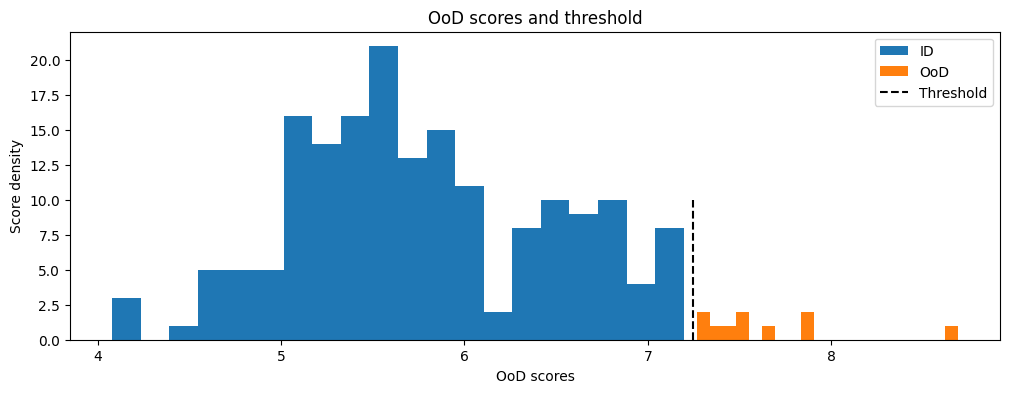

In [106]:
# Plot ood scores and threshold
plot_ood_scores(ood_scores=val_y_ood_scores, threshold=threshold_val)

* **Q4 (1 pts)**: We evaluate your classifier on the test set like in `1.2 Q4`. Is it better than Mahalanobis distance? Why?
    * **Answer**: ...

In [107]:
# Predictions on test set
test_y_hat, test_y_ood_scores = classifier.predict(test_x)

# Compute metrics
test_y_hat_ood, recall_tumor, recall_stroma, recall_ood, avg_recall = compute_metrics(
    y=test_y, y_hat=test_y_hat, ood_scores=test_y_ood_scores, threshold=threshold_val)

# Display metrics
print(f"Tumor recall: {recall_tumor*100:.2f}%")
print(f"Stroma recall: {recall_stroma*100:.2f}%")
print(f"OoD recall: {recall_ood*100:.2f}%")
print(f"Average recall: {avg_recall*100:.2f}%")

Tumor recall: 100.00%
Stroma recall: 95.70%
OoD recall: 99.64%
Average recall: 98.45%


## Part 2 - Lung Adenocarcinoma Classification (19 points)

In the previous exercise, we successfully detected TUMOR and STROMA tissues using a minimum of labels. This allows us to compute the Tumor-Stroma Ratio (TSR), a valuable indicator for determining tumor grade and guiding treatment decisions. However, despite saving annotations, the need for hundreds of tumor/stroma annotations remains prohibitively expensive. Additionally, associating the TSR value with the correct tumor grade and treatment necessitates further algorithmic developments.

An alternative approach involves annotating entire tumor grades on Whole Slide Images (WSIs) and training a classifier directly. However, a significant challenge arises due to the immense size of WSIs, typically containing millions of pixels, which makes direct preprocessing infeasible for computers. To address this challenge, we partition the WSI into thousands of non-overlapping patches. Consequently, each WSI comprises thousands of patch features. However, classifying a conglomerate of features is inherently challenging, especially considering that each WSI may not necessarily contain the same number of patches.

As illustrated in Fig. 2, a highly effective method is to apply an aggregation pooling function, which transforms the pool of features into a single slide feature. Subsequently, we can train a simple classifier to classify the slides. In this section, your objective is to develop a classifier and various pooling methods for classifying WSIs of lung adenocarcinoma patterns.

<br />
<figure>
    <img src="../data/data_lab_03/part_02/wsi.png" width="1100">
    <figcaption>Fig2: WSI classification pipeline.</figcaption>
</figure>
<br />

### 2.1 Dataset (1 pt)

Your objective is to classify lung adenocarcinoma patterns, specifically acinar and solid patterns. Acinar adenocarcinoma typically exhibits glandular structures resembling small sacs when viewed under a microscope, as depicted in Fig. 3. These structures may appear irregular and crowded. Conversely, solid adenocarcinoma, as illustrated in Fig. 4, appears as solid sheets or nests of cells with little to no glandular differentiation.

You'll be working with a subset of the DHMC dataset, comprising 53 acinar examples and 48 solid examples. To assist you, we provide a training set and a validation set, representing 60% and 40% of the data, respectively. In this dataset, features of the patches composing each Whole Slide Image (WSI) have already been extracted using CTransPath. Your initial task is to prepare the data to be suitable for model training.

<br />
<figure>
    <img src="../data/data_lab_03/part_02/acinar.png" width="500">
    <figcaption>Fig3: Example acinar lung adenocarcinoma WSI.</figcaption>
</figure>
<figure>
    <img src="../data/data_lab_03/part_02/solid.png" width="300">
    <figcaption>Fig4: Example solid lung adenocarcinoma WSI.</figcaption>
</figure>
<br />

First download the data [here](https://drive.google.com/drive/folders/1W55290DTTj1ZketmSwLXbRQ-FEQrdees?usp=sharing) and put it under `data/data_lab_03/part_02`.
Before proceeding, ensure that your workspace conforms to the following structure:

```code
├── lab_03_iapr.ipynb
└── data
    └── data_lab_03
        └── part_02
            ├── dhmc_train.pth
            ├── dhmc_val.pth
            ├── dhmc_test.pth
            ├── acinar.png
            ├── solid.png
            ├── wsi.png
            ├── DHMC_0001.png
            └── DHMC_0007.png
```

* **Q1 (1 pt)**: Please complete the `DHMC2Cls` class. The class loads raw data from an external file and stores them in `raw_data`. You are required to implement the `__len__` and `__getitem__` functions. The `__len__` function should return the length M of the dataset, while the `__getitem__` function should return a tuple containing: (1) the patch features, (2) the WSI label, (3) the WSI id, and (4) the patch coordinates. Before proceeding take time to investigate the content of the raw data. It's important to note that in the training mode, you should only return the features and the label.

In [202]:
class DHMC2Cls(Dataset):
    """DHMC dataset using 2 classes"""

    def __init__(self, features_path : str, train : bool = False) -> None:
        """
        Attributes:
            raw_data (list of dict): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = torch.load(features_path)
        # Set if training or not
        self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset

        Returns:
            int: The length M of the dataset
        """

        n_data = 0
        
        # ------------------
        # n_data = len(self.raw_data[0]["label"]) 
        n_data = len(self.raw_data)
        # ------------------
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes}
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        wsi_id = None
        coordinates = None
        
        # ------------------ 
        features = self.raw_data[index]["patch_features"]
        label = self.raw_data[index]["label"]
        if not self.train:
            wsi_id = self.raw_data[index]["wsi_id"]
            coordinates = self.raw_data[index]["patch_coordinates"]
        # ------------------
        
        if self.train:
            return features, label
        else:
            return features, label, wsi_id, coordinates

In [203]:
# Run the block to build the train and validation datasets
dataroot = os.path.join("..", "data", "data_lab_03", "part_02")
train_dataset = DHMC2Cls(os.path.join(dataroot, "dhmc_train.pth"), train=True)
val_dataset = DHMC2Cls(os.path.join(dataroot, "dhmc_val.pth"))

In [216]:
# this is just for debugging        ###  REMOVE LATER  ########
raw_data = train_dataset.raw_data
print("type: ", type(raw_data))
print('raw_data[0]: ', type(raw_data[0]))
first_dic = raw_data[0]
for key in first_dic:
    print(key)

print("patch features: ", first_dic["patch_features"].shape)
print(len(raw_data))
print("patch_coordinates length: ", len(first_dic["patch_coordinates"]))

type:  <class 'list'>
raw_data[0]:  <class 'dict'>
wsi_id
patch_features
label
patch_coordinates
patch features:  torch.Size([10220, 768])
59
patch_coordinates length:  10220


In the cell below we test your training and validation datasets to check for inconsistencies. Your implementation should pass all tests. 

In [204]:
def sanity_check_dataset(train_dataset: Dataset, val_dataset: Dataset):
    """ Automatic check of implementation, DO NOT Modify

    Args:
        train_dataset (Dataset): Training dataset
        val_dataset (Dataset): Validation dataset

    Return:
        status (str): Return "Successful" of all tests passed, "Failed" otherwise
    """
    try:
        # Perform sanity check of the training dataset creation
        assert len(train_dataset) == 59
        features, label = train_dataset[1]
        assert label == 1
        assert np.isclose(features[0, 0], 0.0538, rtol=1e-3)
        
        # Perform sanity check of the validation dataset creation
        assert len(val_dataset) == 40
        features, label, wsi_id, coord = val_dataset[1]
        assert label == 1
        assert np.isclose(features[0, 0], 0.0588, rtol=1e-3)
        assert wsi_id == 'DHMC_0008'
        assert coord[0, 0] == 21697
        
    except Exception:
        return "Failed :("

    return "Successful :)"

status = sanity_check_dataset(train_dataset, val_dataset)
print("Satus of your implementation: {}".format(status))

Satus of your implementation: Successful :)


In [205]:
# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

### 2.2 Average Pooling (1 pt)

You will start with the simplest pooling method, i.e. average pooling. It simply consists of averaging the WSI patch features to form a single one representative of the WSI.

* **Q1 (1 pt)**: Complete the `forward` function in `AveragePooling`. Remember, it takes a set of WSI features with shape `(N x d)`, and should return a single WSI feature of shape `(1 x d)`.

In [313]:
class AveragePooling(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, features : torch.Tensor):
        """ Perform mean along the first dimension of the tensor

        Args:
            features (torch.Tensor): (N, D) Feature to perform average pooling on
        Return:
            mean (torch.Tensor): (1, D) Features average over all patches
        """

        mean = None
        
        # ------------------
        mean = torch.mean(features, dim = 1)
        # ------------------
        
        return mean

In [314]:
def sanity_check_avg(avg_func: Callable):
    """ Automatic check of implementation, DO NOT Modify

    Args:
        avg_func (Dataset): Average pooling function

    Return:
        status (str): Return "Successful" of all tests passed, "Failed" otherwise
    """
    try:
        # Sanity check for average function
        x_in = torch.Tensor([[0, 3], [4, 6], [2, 0]])
        x_out = torch.Tensor([[2, 3]])
        assert np.all(np.isclose(AveragePooling().forward(features=x_in), x_out, rtol=1e-3))
        
    except Exception:
        return "Failed :("

    return "Successful :)"

sanity_check_avg(AveragePooling)

'Failed :('

### 2.3 Classifier (7 pts)

Now that you have coded your first aggregation method, let's build the linear classifier.

* **Q1 (3 pts)**: 
    * Complete the `Classifier` class below. You should fill `__init__` which assigns the attributes. Attributes are :
        * `proj` is a nonlinear projection layer that adapts the features for the task. It is simply a linear layer that projects features of dimension `d` to features of lower dimension `H`. Then it is followed by a ReLU.
        * `pool`, the pooling function.
        * `fc`, the final linear classifier layer. 
    * Complete `forward` which given a pool of features of shape `(1 x N x d)` outputs the class prediction logits of shape `(1 x 2)`.

In [315]:
class LinearClassifier(nn.Module):

    def __init__(self, in_dim : int, H : int, n_classes : int, pooling_fn : nn.Module) -> None:
        """Constructs the linear classifier

        Attributes:
            proj (Callable): Projection of layer (N, d) -> (N, H)
            pool (Callable): Pooling layer (N, H) -> (1, H)
            fc (Callable): Classification layer (1, H) -> (1, n_classes)
            
        Args:
            in_dim (int): The dimension of input features
            H (int): Target dimension for the projection layer
            n_classes (int): The number of classes for the task
            pooling_fn (nn.Module): The pooling function to aggregate the features
        """
        super().__init__()

        proj_layer = None
        pool_layer = None
        fc_layer = None
        
        # ------------------
        proj_layer = nn.Linear(in_features=in_dim, out_features=H)
        pool_layer = AveragePooling().forward
        fc_layer = nn.Linear(in_features = H , out_features = n_classes)
        # ------------------

        self.proj = proj_layer
        self.pool = pool_layer
        self.fc = fc_layer
        

    def forward(self, x):
        """Forward path

        Args:
            x (torch.Tensor): (1, N, d) Input feature for a given slide with N patches
        Return:
            logits (torch.Tensor): (1, n_classes) Output logits for classification
        """

        logits = None
        
        # ------------------
        # x = x[0] #??
        
        print("original x: ", x.shape)
        x = self.proj(x)
        print("x1: ", x.shape )
        x = F.relu(x)
        print("x2: ", x.shape )
        x = self.pool(features = x)
        print("x3: ", x.shape )
        # Flatten before Fully Connected Layer
        # x = x.view(x.size(0), -1)
        # print("x4: ", x.shape)
        logits = self.fc(x)
        print("x5: ", logits.shape)
        # ------------------

        return logits

In [316]:
def sanity_check_cls(cls_class: Callable):
    """ Automatic check of implementation, DO NOT Modify

    Args:
        avg_func (nn.Module): Linear classifier

    Return:
        status (str): Return "Successful" of all tests passed, "Failed" otherwise
    """
    try:
        # Test of implementation
        d, H, n_classes = 768, 512, 2
        cls = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AveragePooling())
        assert cls(torch.zeros((1, 1000, d))).shape == torch.Size([1, n_classes])
        
    except Exception:
        return "Failed :("

    return "Successful :)"

sanity_check_cls(LinearClassifier)

original x:  torch.Size([1, 1000, 768])
x1:  torch.Size([1, 1000, 512])
x2:  torch.Size([1, 1000, 512])
x3:  torch.Size([1, 512])
x5:  torch.Size([1, 2])


'Successful :)'

The classifier is ready to train. It remains to write the code to optimize your model.

* **Q2 (2 pts)**: Please complete the `train` function below. This function should take `train_loader`, `val_loader`, `n_epochs`, and an `optimizer` as inputs. It is responsible for training the `model` and returning the best model checkpoint, best F1 score, and the epoch at which the best F1 score was achieved on the validation set.

**Notes**: 
* Refer to this [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for guidance on training a classifier.
* To obtain the model checkpoint, simply call `model.state_dict()`.
* We provide you the `test` function that computes the F1 score on a given test dataset. **You should not modify it !!!**

In [286]:
@torch.no_grad()
def test(model : nn.Module, test_loader : DataLoader):
    """The test function, computes the F1 score of the current model on the test_loader

    Args:
        model (nn.Module): The model to evaluate
        test_loader (DataLoader): The test data loader to iterate on the dataset to test

    Returns:
        f1 (float): The F1 score on the given dataset
        loss (float): Averaged loss on the given dataset
    """
    model.eval()

    preds_dict = {"preds" : torch.Tensor(), "labels" : torch.Tensor(), 'losses': torch.Tensor()}
    for features, labels, _, _ in test_loader:
        # Forward and loss
        preds = model(features)
        loss = F.cross_entropy(preds, labels)
        
        # Store values
        preds_dict["preds"] = torch.cat([preds_dict["preds"], preds.argmax(1)])
        preds_dict["labels"] = torch.cat([preds_dict["labels"], labels])
        preds_dict["losses"] = torch.cat([preds_dict["losses"], loss[None]])

    # Compute metric and loss
    f1 = f1_score(preds_dict["labels"], preds_dict["preds"], average="macro")
    loss = preds_dict["losses"].mean()

    return f1, loss

In [ ]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer):
    """Trains the neural network self.model for n_epochs using a given optimizer on the training dataset.
    Outputs the best model in terms of F1 score on the validation dataset.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): The training dataloader to iterate on the training dataset
        val_loader (DataLoader): The validation dataloader to iterate on the validation dataset
        n_epochs (int): The number of epochs, i.e. the number of time the model should see each training example
        optimizer (torch.optim.Optimizer): The optimizer function to update the model parameters

    Returns:
        best_model (nn.Module): Best model state dictionary 
        best_f1 (float): Best F1-score on the validation set
        best_epoch (int): Best epoch on validation set
        val_f1s (list of floats): (n_epochs, ) F1-scores for all epochs
        val_losses (list of floats): (n_epochs, ) Losses for all validation epochs
        train_losses(list of floats): (n_epochs, ) Losses for all training epochs
    """

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []

    # ------------------
    # Your code here ... 
    # ------------------
    
    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

* **Q3 (1 pt)**: Train a linear classifier using `AveragePooling` for `30` epochs, employing the `Adam` optimizer with a learning rate of `1e-3`. No need to search for optimal hyperparameters. Refer to the PyTorch documentation for guidance on constructing your optimizer. Use `H=512`. Don't worry, the training might take ~5-10 minutes. Your results should be above (87%).
    * **Answer**: ...

In [ ]:
# Set seed for reproducibility
torch.manual_seed(0)

# Display loss progression and f1 score
epochs = 30
d, H, n_classes = 768, 512, 2

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AveragePooling())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Run training and display results
_, best_f1, best_epoch, val_accs, val_loss, train_loss = train(model, train_loader, val_loader, n_epochs=epochs, optimizer=optimizer)
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

In [ ]:
def plot_training(best_epoch: int, val_accs: list, val_loss: list, train_loss: list):
    """Plot training results of linear classifier
    
    Args:
        best_epoch (int): Best epoch
        val_accs (List): (E,) list of validation measures for each epoch
        val_loss (List): (E,) List of validation losses for each epoch
        train_loss (List): (E,) List of training losses for each epoch
    """

    # Create plot
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    es = np.arange(1, len(val_accs)+1)
    # Plot F1 score
    axes[0].plot(es, val_accs, label="Val")
    axes[0].vlines(best_epoch, ymin=np.min(val_accs), ymax=np.max(val_accs), color='k', ls='--', label="Best epoch")
    axes[0].set_xlabel("Training steps")
    axes[0].set_ylabel("F1-score")
    axes[0].set_title("F1-score")
    axes[0].legend()

    # Plot losses
    axes[1].plot(es, val_loss, label="Val")
    axes[1].plot(es, train_loss, label="Train")
    axes[1].vlines(best_epoch, ymin=np.min(train_loss), ymax=np.max(val_loss), color='k', ls='--', label="Best epoch")
    axes[1].set_xlabel("Training steps")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Losses")
    axes[1].legend()
    
    plt.tight_layout()

# Plot results
plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

* **Q4 (1 pt)**: Are you satisfied with the results? What is the primary disadvantage of employing average pooling? Does the model overfit the data? (justify)
    * **Answer**: ...

### 2.4 Attention Pooling (10 pts)

Now you will build a more advanced pooling method, called attention pooling. The motivation for this method should result from your analysis in `2.3 Q4`. So we will not share much information with you on this one. Instead, we refer you to the related paper [here](https://arxiv.org/pdf/1802.04712.pdf).

* **Q1 (4 pts)**: Complete `Attn_Net_Gated` which implements the gated attention mechanism described in the paper. Note `L`, and `M` are the dimension of the projection weights. You will find similar notations in the paper.

In [ ]:
class Attn_Net_Gated(nn.Module):
    def __init__(self, L : int, M : int):
        """
        Attention Network with Sigmoid Gating (3 fc layers)
        Args:
            L: input feature dimension
            M: hidden layer dimension
        """
        super(Attn_Net_Gated, self).__init__()

        # ------------------
        # Your code here ... 
        # ------------------

    def forward(self, x):
        """Forward path of the gated attention network

        Args:
            xin: (N, L) List of N patches and L features
        Return:
            A: (N, 1) Attention value for each patch
        """
        # ------------------
        # Your code here ... 
        # ------------------

        return A

In [ ]:
def sanity_gated(func_gated: Callable):
    """ Automatic check of implementation, DO NOT Modify

    Args:
        avg_func (nn.Module): Attention gated

    Return:
        status (str): Return "Successful" of all tests passed, "Failed" otherwise
    """
    try:
        # Test of implementation
        L, M = 512, 256
        layer = func_gated(L, M)
        # Check output size
        xin = torch.zeros(1000, L)
        assert layer(xin).size() == torch.Size([1000, 1])
    except Exception:
        return "Failed :("

    return "Successful :)"

sanity_gated(Attn_Net_Gated)

* **Q2 (3 pts)**: Complete `AttentionPooling`, which performs attention pooling with the help of the gated attention mechanism. In `forward`, you should only return the attention if `attention_only=True`.

In [ ]:
class AttentionPooling(nn.Module):
    def __init__(self, L : int, M : int):
        super().__init__()
        # Intatiate the gated layer
        self.attention_net = Attn_Net_Gated(L, M)

    def forward(self, x, attention_only : bool = False):
        """Forward pass

        Args:
            x (torch.tensor): (N, L) Input feature over N patches and L features
            attention_only (bool): Say whether to return the attention or not
        Returns:
            Y (torch.Tensor): (1, N) Output, if attention_only==False
            A (torch.Tensor): (1, N) Attention values, if attention_only==True
        """

        A = None
        Y = None
        
        # ------------------
        # Your code here ... 
        # ------------------

        # Check if need to return attention
        if attention_only:
            return A
        else:
            return Y

* **Q3 (1 pt)**: Train your linear classifier using `AttentionPooling` with `M=256`. You will train your model for `30` epochs, employing the `Adam` optimizer with a learning rate of `1e-4`. No need to search for optimal hyperparameters. Use `H=512`. Don't worry, the training should take ~5-10 minutes. Your results should be above (90%).
    * **Answer**: ...

In [ ]:
# Set seed for reproducibility
torch.manual_seed(0)

# Display loss progression and f1 score
epochs = 30
d, H, M, n_classes = 768, 512, 256, 2

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AttentionPooling(H, M))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Run training and display results
best_model, best_f1, best_epoch, val_accs, val_loss, train_loss = train(model, train_loader, val_loader, n_epochs=epochs, optimizer=optimizer)
print(f"Best model at epoch {best_epoch} -> {100*best_f1:.2f}% F1 score")

In [ ]:
# Plot results
plot_training(best_epoch=best_epoch, val_accs=val_accs, val_loss=val_loss, train_loss=train_loss)

We have kept one example per class for testing and visualization. We have `DHMC_0001.jpg` presenting solid adenocarcinoma patterns and `DHMC_0007.jpg` with acinar adenocarcinoma. Those examples have never been seen in training and validation.

* **Q4 (1 pt)**: Test your best attention model on the test dataset below. Use `load_state_dict()` to load the model weights.

In [ ]:
# Load test dataset
test_dataset = DHMC2Cls(os.path.join(dataroot, "dhmc_test.pth"))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

# Create a model from the best model state
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AttentionPooling(H, M))
model.load_state_dict(best_model)
test_f1, _ = test(model, test_loader)

print(f"Test F1 score: {100*test_f1:.2f}%")

As stated in the paper, a benefit of incorporating an attention layer is the enhanced interpretability of the model's decision-making process. This feature is particularly crucial for ensuring the safe deployment of deep learning models, especially in sensitive domains such as the medical field. With an attention layer, it becomes possible to discern the most critical patches that the model considered for a particular decision. To visualize this, please execute the three cells below to observe the attention maps on the test examples. **Don't forget to answer the question in the end !!!**

In [ ]:
def build_prediction_map(
        coords_x: np.ndarray,
        coords_y:  np.ndarray,
        feature:  np.ndarray,
        wsi_dim: Optional[tuple] = None,
        default: Optional[float] = -1.,
):
    """
    Build a prediction map based on x and y coordinates and feature vectors. Default values if feature is nonexisting
    for a certain location is -1.

    Parameters
    ----------
    coords_x: np.ndarray of shape (N,)
        Coordinates of x points.
    coords_y: np.ndarray of shape (N,)
        Coordinates of y points.
    feature: np.ndarray of shape (N, M)
        Feature vector.
    wsi_dim: tuple of int, optional
        Size of the original whole slide.
    default: float, optional
        Value of the pixel when the feature is not defined.

    Returns
    -------
    map: np.ndarray (W, H, M)
        Feature map. The unaffected points use the default value -1.
    map_x, map_y: np.ndarray (W, H), np.ndarray (W, H)
        Corresponding and y coordinates of the feature map.
    """
    # Compute offset of coordinates in pixel (patch intervals)
    interval_x = np.min(np.unique(coords_x)[1:] - np.unique(coords_x)[:-1])
    interval_y = np.min(np.unique(coords_y)[1:] - np.unique(coords_y)[:-1])

    # Define new coordinates
    offset_x = np.min(coords_x) % interval_x
    offset_y = np.min(coords_y) % interval_y
        
    coords_x_ = ((coords_x - offset_x) / interval_x).astype(int)
    coords_y_ = ((coords_y - offset_y) / interval_y).astype(int)

    # Define size of the feature map
    map = default * np.ones((int(wsi_dim[1] / interval_y), int(wsi_dim[0] / interval_x), feature.shape[1]))
    map[coords_y_, coords_x_] = feature
    
    return map

In [ ]:
@torch.no_grad()
def plot_attention(model, test_loader):
    """ Plot attention on top of slide images

    Args:
        model (nn.Module): Model 
        test_loader (Dataloader): Data loader for the test set
    """
    
    # Define new plot
    fig, ax = plt.subplots(2, 2, figsize=(16, 10), height_ratios=[3, 2], width_ratios=[1, 1.25])

    # iterate over slides
    for i, (features, _, wsi_id, coordinates) in enumerate(test_loader):

        # Get data and paths
        wsi_id = wsi_id[0]
        slide_path = os.path.join(dataroot, f"{wsi_id}.jpg")
        # Forward path
        attention = model.pool(model.proj(features.squeeze()), attention_only=True).squeeze()

        # Get WSI dim (Hardcoded)
        if wsi_id == "DHMC_0001":
            label = "Solid"
            wsi_dim= (39839, 30468)
        elif wsi_id == "DHMC_0007":
            label = "Acinar"
            wsi_dim = (47808, 22631)
        else:
            raise NotImplementedError("There is a problem !")

        # Plot results
        slide_im = np.array(Image.open(slide_path))
        ax[i][0].imshow(slide_im)
        ax[i][0].set_title(label)
        ax[i][0].axis('off')
        
        # Show prediction overlay
        prob_map = build_prediction_map(
                coords_x=coordinates[0,:, 0].numpy(),
                coords_y=coordinates[0,:, 1].numpy(),
                feature=attention[:, None],
                wsi_dim=wsi_dim,
                default=0,
        )[:, :, 0]

        # Rescale to ouput map size
        prob_map = F.interpolate(torch.Tensor(prob_map)[None, None], slide_im.shape[:2], mode='bilinear', align_corners=False)[0, 0]

        # Plot prediction map
        ax[i][1].imshow(slide_im)
        pcm = ax[i][1].imshow(prob_map, cmap=matplotlib.colormaps['hot'], vmax=torch.quantile(attention, q=0.99), alpha=0.5)
        ax[i][1].axis('off')
        # Add colorbar
        fig.colorbar(pcm, ax=ax[i][1])
        plt.tight_layout()

In [ ]:
plot_attention(model, test_loader)

* **Q5 (1pt)**: From the visualization above, what can you interpret?
    * **Answer**: ...